# Тестовое задание.
## Определить абонентов (msisdn), которые являются одной и той же Персоной (человеком).

In [1]:
import pandas as pd
import os
from os import walk
import datetime
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date

import csv

import folium
from folium import plugins
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

Загружаем данные и преобразуем в удобный формат некоторые поля

In [2]:
current_directory = r'C:\Users\ekaterina.adischeva\Documents\Scripts\BD_task\Техническое задание_аналитик больших данных\Данные'
current_directory = current_directory.replace('\\','/')
os.chdir(current_directory)

In [3]:
df_data = pd.read_csv('02_Data.csv', sep = ';', dtype = {'imei': str, 'lac' : 'str', 'cid' : 'str'})
facts = pd.read_excel('01_Факты.xlsx', header = None)
tac_dict = pd.read_csv('03_устройства.csv', quoting=csv.QUOTE_NONE)
event_type = pd.read_excel('04_event_type.xlsx')

In [4]:
tac_dict.columns = tac_dict.columns.str.replace('\"','')
for column_name in tac_dict.columns:
    tac_dict[column_name] = tac_dict[column_name].str.replace('\"','')

Преобразуем в datetime время регистрации события на базовой станции (количество 1/1000 секунды, прошедших с 01.01.1970 до времени регистрации на БС.)

Выделяем tac из поля imei 

In [5]:
df_data['datetime'] = pd.to_timedelta(df_data['tstamp']/1000, unit='S') + pd.Timestamp('1970-1-1')
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

df_data['tac'] = df_data['imei'].str.slice(0,8)

Подгружаем значения из справочников в данные о перемещении абонентов 

In [6]:
df_data = df_data.merge(event_type, left_on = ['event_type'], right_on = 'Номер', how = 'left')
df_data = df_data.merge(tac_dict, on = ['tac'], how = 'left')

# Графики и функции
`show_chart` отображает изменение координат широты и долготы по времени

In [7]:
def show_chart(fig, data_a, data_b ):
    """
    The function draws 2 chatrs: msisdn lattitude on time and msisdn longitude on time

"""

    data_a_copy = data_a
    data_b_copy = data_b

    plt.subplot(1, 2, 1)
    feature = 'long'
    plt.scatter(data_a_copy['datetime'], data_a_copy[feature], alpha = .5, c = 'blue')
    plt.plot(data_a_copy['datetime'], data_a_copy[feature+'_max'],'-o',alpha = .3, color='blue')
    plt.plot(data_a_copy['datetime'], data_a_copy[feature+'_min'],'-o',alpha = .3, color='blue')
    plt.scatter(data_b_copy['datetime'], data_b_copy[feature], alpha = .5, c = 'red')
    plt.plot(data_b_copy['datetime'], data_b_copy[feature+'_max'],'-o',alpha = .3, color='red')
    plt.plot(data_b_copy['datetime'], data_b_copy[feature+'_min'],'-o',alpha = .3, color='red')
    plt.xlim(pd.concat([data_a,data_b])['datetime'].min(), pd.concat([data_a,data_b])['datetime'].max())
    plt.xticks(rotation=70)

    plt.subplot(1, 2, 2)
    feature = 'lat'
    plt.scatter(data_a_copy['datetime'], data_a_copy[feature], alpha = .5, c = 'blue')
    plt.plot(data_a_copy['datetime'], data_a_copy[feature+'_max'],'-o',alpha = .3, color='blue')
    plt.plot(data_a_copy['datetime'], data_a_copy[feature+'_min'],'-o',alpha = .3, color='blue')
    plt.scatter(data_b_copy['datetime'], data_b_copy[feature], alpha = .5, c = 'red')
    plt.plot(data_b_copy['datetime'], data_b_copy[feature+'_max'],'-o',alpha = .3, color='red')
    plt.plot(data_b_copy['datetime'], data_b_copy[feature+'_min'],'-o',alpha = .3, color='red')
    plt.xlim(pd.concat([data_a,data_b])['datetime'].min(), pd.concat([data_a,data_b])['datetime'].max())
    plt.xticks(rotation=70)
    
    plt.show()
    return fig

`show_circles_on_map` отображает точки в которых был абонент на карте

In [8]:
def show_circles_on_map(m, data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True,
            fill_opacity = .5
        ).add_to(m)

    return m

`haversine_array` определяет расстояние в метрах по координатам

In [9]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

## Проверяем данные
Смотрим, где в выборке есть пустые данные

In [10]:
df_data.count() - df_data.shape[0], df_data.dtypes

(lac                0
 cid                0
 msisdn             0
 imei          -11588
 event_type         0
 tstamp             0
 long               0
 lat                0
 max_dist           0
 cell_type          0
 start_angle        0
 end_angle          0
 datetime           0
 tac           -11588
 Номер              0
 Обозначение        0
 Описание           0
 vendor        -23679
 platform      -23679
 type          -23679
 dtype: int64, lac                    object
 cid                    object
 msisdn                  int64
 imei                   object
 event_type              int64
 tstamp                  int64
 long                  float64
 lat                   float64
 max_dist                int64
 cell_type              object
 start_angle           float64
 end_angle             float64
 datetime       datetime64[ns]
 tac                    object
 Номер                   int64
 Обозначение            object
 Описание               object
 vendor            

Некоторые номера, принадлижайщие Персонам, не попали в выборку с детальными данными

In [11]:
# for 2 persons we don't have second msisdn in our dataset
display(facts[~facts[1].isin(df_data['msisdn'])], 
        facts[~facts[0].isin(df_data['msisdn'])])

,0,1
1,158510912201,158528852857
17,158528850493,158530004641


,0,1


Смотрим распределение событий по времени. В выборке есть данные, датированные позже 26 мая. Удаляем данные с датой более 26 мая.

C:\Users\ekaterina.adischeva\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


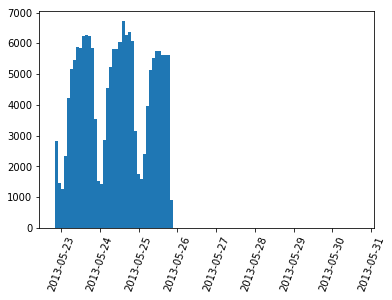

In [12]:
plt.hist(df_data['datetime'].values, bins=100)
plt.xticks(rotation=70)
plt.show()

In [13]:
df_data.loc[:, 'date'] = df_data['datetime'].dt.date
print(df_data['date'].value_counts())
df_data = df_data[(df_data['datetime']  < datetime.strptime('2013-05-26', '%Y-%m-%d'))
         #         & (df_data['datetime']  >= datetime.strptime('2013-05-23', '%Y-%m-%d'))
                 ]

2013-05-24    61642
2013-05-23    59463
2013-05-25    48519
2013-05-22     4450
2013-05-29       24
2013-05-28       18
2013-05-30        7
Name: date, dtype: int64


## Проверяем базовые станции.
* Распоболение базовых станций на карте.
* Распоболение ширины угла.
* Распоболение зоны действия в метрах.

In [14]:
CENTER_LAT, CENTER_LONG = 55.7522200, 37.6155600
m = folium.Map(location=(CENTER_LAT, CENTER_LONG))
show_circles_on_map(m, df_data.sample(500), "lat", "long", "blue")

In [15]:
df_data['angel'] = np.where(df_data['end_angle'] < df_data['start_angle'], df_data['end_angle'] - df_data['start_angle'] + 360,
                        df_data['end_angle'] - df_data['start_angle'])

df_data['angel'].value_counts()

60.0     156940
47.0       9719
90.0       3104
360.0      2176
65.0       2135
Name: angel, dtype: int64

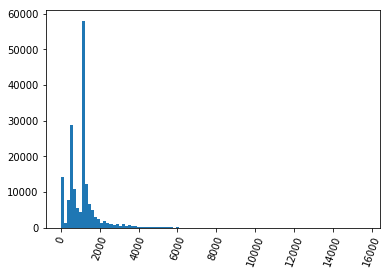

In [16]:
plt.hist(df_data['max_dist'].values, bins=100)
plt.xticks(rotation=70)
plt.show()

## Указываю координаты зоны действия БС для каждого события

По координатам БС, максимальной дистанции приема и направления и угла покрятия определяем координаты прямоугольника, в которых мог находиться абонент при регистрации на БС

In [17]:
def BS_rectangle_coordinate(df_):
    df = df_.copy()
    lat_length = haversine_array(CENTER_LAT -.5, CENTER_LONG, CENTER_LAT + .5, CENTER_LONG)
    long_length = haversine_array(CENTER_LAT, CENTER_LONG -.5, CENTER_LAT, CENTER_LONG + .5)
    max_dist_mean = df['max_dist'].mean()

    df['max_dist_correct'] = np.where(df['max_dist'] < 50, max_dist_mean, df['max_dist'])
    df['max_dist_correct']
    
    for feature in ['long', 'lat']:
        if (feature == 'long'):
            coord_length = long_length
        else:
            coord_length = lat_length
        df[feature + '_start'] = np.where(df['angel'] == 360,
                                 df[feature] - df['max_dist_correct']/coord_length/1000,
                                 df[feature] + df['max_dist_correct'] * np.where(feature == 'long', 
                                                                                           np.sin(df['start_angle']),
                                                                                           np.cos(df['start_angle'])
                                                                                                 )/coord_length/1000)

        df[feature + '_end'] = np.where(df['angel'] == 360,
                               df[feature]+df['max_dist_correct']/coord_length/1000,
                               df[feature] + df['max_dist_correct'] * np.where(feature == 'long', 
                                                                                           np.sin(df['end_angle']),
                                                                                           np.cos(df['end_angle'])
                                                                                                 )/coord_length/1000)
                                                                                         
        df[feature + '_min'] = df[[feature + '_start', feature + '_end', feature]].min(axis = 1)
        df[feature + '_max'] = df[[feature + '_start', feature + '_end', feature]].max(axis = 1)
        
        df[feature] = (df[feature + '_max'] + df[feature + '_min'])/2
    return df

In [18]:
df_data_copy = df_data.copy()
df_data = BS_rectangle_coordinate(df_data_copy)

## Создаю bin по времени для создания ряда событий

In [19]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import make_blobs

def CreateTimeBeans(df_, n_bins_ = 10):
    df = df_.copy()
    
    dt_list = np.reshape(df.datetime.values.tolist(), (len(df.datetime.values.tolist()), 1))

    enc = KBinsDiscretizer(n_bins=n_bins_, encode='ordinal', strategy='uniform')
    dt_array_bins = enc.fit_transform(dt_list)

    df['datetime_bin'] = dt_array_bins[:,0]
    df['datetime_bin'] = df['datetime_bin'].astype('int')

    return df, df['datetime_bin'].unique()

In [20]:
'''
sns.relplot(data=df_data_bin.groupby(['datetime_bin', 'day_of_month'])['lac'].count().reset_index(),
            y="lac", x="datetime_bin", hue = 'day_of_month')
'''

'\nsns.relplot(data=df_data_bin.groupby([\'datetime_bin\', \'day_of_month\'])[\'lac\'].count().reset_index(),\n            y="lac", x="datetime_bin", hue = \'day_of_month\')\n'

# Аггрегирую таблицу с событиями для преобразования в ряд.
При необходимости, добавляю технические события в пустые интервалы времени

In [21]:
# декартовое произведение абонентов и интервалов
def CreatePivotBase(df):
    # декартовое произведение абонентов и часов
    df_data_msisdn = pd.DataFrame(df['msisdn'].drop_duplicates()).sort_values('msisdn')
    df_data_datetime = pd.DataFrame(df['datetime_bin'].drop_duplicates()).sort_values('datetime_bin')

    df_data_msisdn['K'] = 1
    df_data_datetime['K'] = 1
    df_data_pivot_base = df_data_msisdn.merge(df_data_datetime, on = ['K']).reset_index().drop(columns = ['index', 'K'])
    
    return df_data_pivot_base

In [ ]:
# аггрегация данных по интервалам
def AggData(df):
    #Создаем датафрейм в котором записаны часовые срезы расположения абонента и нумеруем в хронологическом порядке каждое состояние

    df_data_agg = df.groupby(['msisdn',  'datetime_bin'])['long_min', 'long_max', 'lat_min', 'lat_max', 'long', 'lat'].mean().reset_index()
    df_data_agg['datetime'] = df_data_agg['datetime_bin'] 
    df_data_agg = df_data_agg.sort_values(['msisdn', 'datetime_bin'])
    df_data_agg['state'] = df_data_agg.groupby(['msisdn'])['msisdn'].cumcount()
    return df_data_agg

In [ ]:
# cдвигаю событие на пол часа и объединяю с оригинальными событиями
from datetime import timedelta
def AddDataDelta(df_):
    df_delta = df_.copy()
    df_delta['datetime'] = df_delta['datetime'] - timedelta(seconds = (60*60))
    df = df_.copy()
    df = df.append(df_delta)
    return df

In [ ]:
# Промежутки времени, в которых не зафиксировано действие абонента, заполняю линейном комбинацией координат окружающих событий.
# Концевые точки продолжаю до границы интрервала наблюдения константами.

def LinearCombData(df_data_pivot_base, df_data_agg):
    
    df_data_pivot_base = df_data_pivot_base.merge(df_data_agg[['msisdn', 'datetime_bin', 'state']], on = ['msisdn', 'datetime_bin'], how = 'left')
    # указываю состояние, в котором произошло предыдущее событие
    df_data_pivot_base['state_previous'] = 1- df_data_pivot_base['state'].isna()*1
    df_data_pivot_base['state_previous'] = df_data_pivot_base.groupby('msisdn')['state_previous'].cumsum() - 1
    
    # указываю состояние, в котором произойдет следующее событие
    df_data_pivot_base.drop(columns = ['state'], inplace = True)
    df_data_pivot_base['state_next'] = df_data_pivot_base['state_previous'] + 1
    # подгружаю информацию о предыдущем и следующем событии
    for event in ['previous', 'next']:
        df_data_pivot_base = df_data_pivot_base.merge(df_data_agg[['msisdn', 'long', 'long_max', 'long_min',
                                                               'lat', 'lat_max', 'lat_min', 'datetime_bin', 'state']].rename(
                                                                    columns =
                                                                            {'long':'long_' + event,
                                                                             'lat':'lat_' + event,
                                                                             'long_max':'long_max_' + event,
                                                                             'lat_max':'lat_max_' + event,
                                                                             'long_min':'long_min_' + event,
                                                                             'lat_min':'lat_min_' + event,
                                                                              'datetime_bin':'datetime_bin_' + event,
                                                                              'state':'state_' + event}),
                                                                    on = ['msisdn', 'state_' + event],
                                                                    how = 'left')
    for feature in ['long', 'long_max', 'long_min', 'lat', 'lat_max', 'lat_min']:
    # расчитываю текущее событие для кажждого периода как линейную комбинацию окружающих реальных событий
        df_data_pivot_base[feature] = np.where(df_data_pivot_base[feature+'_previous'].isna(),
                                       df_data_pivot_base[feature+'_next'],
                                       np.where(df_data_pivot_base[feature+'_next'].isna(),
                                               df_data_pivot_base[feature+'_previous'],
                                               df_data_pivot_base[feature+'_previous'] + 
                                                    (df_data_pivot_base['datetime_bin'] - df_data_pivot_base['datetime_bin_previous'])/
                                                    (df_data_pivot_base['datetime_bin_next'] - df_data_pivot_base['datetime_bin_previous'])*
                                                    (df_data_pivot_base[feature+'_next'] - df_data_pivot_base[feature+'_previous'])))              
                                    

    return df_data_pivot_base[['msisdn', 'datetime_bin', 'long', 'long_max', 'long_min', 'lat', 'lat_max', 'lat_min']]

In [ ]:
# Промежутки времени, в которых не зафиксировано действие абонента, заполняю линейном комбинацией координат окружающих событий.
# Концевые точки продолжаю до границы интрервала наблюдения константами.

def CombData(df_data_pivot_base, df_data_agg):
    
    df_data_pivot_base = df_data_pivot_base.merge(df_data_agg, on = ['msisdn', 'datetime_bin'], how = 'left')

    return df_data_pivot_base[['msisdn', 'datetime_bin', 'long', 'long_max', 'long_min', 'lat', 'lat_max', 'lat_min']]

In [ ]:
# Создаеь pivot из исходной таблицы
def CreatePivot(df_for_pivot):
    df_pivot = df_for_pivot.pivot(index = 'msisdn', columns = 'datetime_bin', values = 'long')
    df_pivot.columns = df_pivot.columns.astype('str') + '_' + 'long'

    for feature in ['long_max', 'long_min', 'lat', 'lat_max', 'lat_min']:
        df_agg_feature = df_for_pivot.pivot(index = 'msisdn', columns = 'datetime_bin', values = feature)
        df_agg_feature.columns = df_agg_feature.columns.astype('str') + '_' + feature
        df_pivot = pd.concat([df_pivot, df_agg_feature], axis = 1)

    return df_pivot.reset_index()

In [ ]:
# Определяем пары, для которых знаем результаты
# * пары - все, которые указаны в таблице facts
# * не пары: номер, у которого есть пара с ЛЮБЫМ номером не из своей пары (этот номер не обязательно из таблицы facts)
# Упрощение, что нет троек номеров.

def CreateMsisdnPairs(train_pairs, df, frac_):
    msisdn_pairs = pd.concat([train_pairs[[0, 1]].rename(columns = {0:'msisdn_x', 1:'msisdn_y'})
  #                        ,facts[[1, 0]].rename(columns = {1:'msisdn_x', 0:'msisdn_y'})
                         ], axis = 0)
    msisdn_pairs_dubli = pd.concat([train_pairs[[0, 1]].rename(columns = {0:'msisdn_x', 1:'msisdn_y'})
                         ,train_pairs[[1, 0]].rename(columns = {1:'msisdn_x', 0:'msisdn_y'})
                         ], axis = 0)
    msisdn_pairs['is_pair'] = 1
    msisdn_pairs['K'] = 1
    msisdn_pairs_dubli['K'] = 1
    
    df_data_msisdn = pd.DataFrame(df['msisdn'].drop_duplicates()).sort_values('msisdn')
    df_data_msisdn['K'] = 1

    # любой номер из пары с другими номерами не создает пары
    msisdn_pairs_part1 = df_data_msisdn[~df_data_msisdn['msisdn'].isin(msisdn_pairs_dubli['msisdn_x'])].rename(columns= {'msisdn':'msisdn_x'}).merge(msisdn_pairs_dubli[['K', 'msisdn_y']], on = ['K']).drop(columns = ['K'])
    msisdn_pairs_part1['is_pair'] = 0
    
    msisdn_pairs_part1 = msisdn_pairs_part1.sample(frac = frac_)

    # объедтняю пары и не пары
    msisdn_pairs = pd.concat([msisdn_pairs, msisdn_pairs_part1
                         # , msisdn_pairs_part2
                         ], axis = 0).drop(columns = ['K'])
    
    # перемешиваю первый и второй номер
    msisdn_pairs_part1 = msisdn_pairs.sample(frac = .5)
    msisdn_pairs_part2 = msisdn_pairs.append(msisdn_pairs_part1).drop_duplicates(keep = False).rename(columns = {'msisdn_x':'msisdn_y', 'msisdn_y':'msisdn_x'})
    msisdn_pairs = msisdn_pairs_part1.append(msisdn_pairs_part2)
    print(msisdn_pairs.shape)
    
    return msisdn_pairs

In [ ]:
#Создаю таблицу для обучения

def CreateAndProcessPivot(msisdn_pairs, data_agg_pivot, bins_list, identifier,
                          dist_ind = True,
                          coord_ind = True,
                          center_dist_ind = True ):
    
    df_X = msisdn_pairs.merge(data_agg_pivot.rename(columns = {'msisdn':'msisdn_x'}), on = ['msisdn_x']).merge(data_agg_pivot.rename(columns = {'msisdn':'msisdn_y'}), on = ['msisdn_y'])
    # считаю расстояние в каждом часе
    columns_name_dist = list()
    columns_name_intersect = list()
    columns_name_lat_x = list()
    columns_name_long_x = list()
    columns_name_lat_y = list()
    columns_name_long_y = list()
    columns_name_center_dist_x = list()
    columns_name_center_dist_y = list()
    
    columns_name = list()
    columns_name_identifier = list()

    lat_length = haversine_array(CENTER_LAT -.5, CENTER_LONG, CENTER_LAT + .5, CENTER_LONG)
    long_length = haversine_array(CENTER_LAT, CENTER_LONG -.5, CENTER_LAT, CENTER_LONG + .5)

    for i in bins_list:
        str_i = str(int(i))
        columns_name_dist.append(str_i+"_dist")
        columns_name_intersect.append(str_i+"_intersect")
        columns_name_lat_x.append(str_i+"_lat_x")
        columns_name_long_x.append(str_i+"_long_x")
        columns_name_lat_y.append(str_i+"_lat_y")
        columns_name_long_y.append(str_i+"_long_y")
        columns_name_center_dist_x.append(str_i+"_center_dist_x")
        columns_name_center_dist_y.append(str_i+"_center_dist_y")

        lat_diff = (df_X[str_i+"_lat_x"].values - df_X[str_i+"_lat_y"].values)*lat_length
        long_diff = (df_X[str_i+"_long_x"].values - df_X[str_i+"_long_y"].values)*long_length
        dist = np.sqrt(lat_diff**2 + long_diff**2)
        df_X[str_i+"_dist"] = dist
        df_X[str_i+'_intersect'] = ((df_X[str_i+'_lat_max_x'] >= df_X[str_i+'_lat_min_y']) &
                              (df_X[str_i+'_lat_max_y'] >= df_X[str_i+'_lat_min_x']) &
                              (df_X[str_i+'_long_max_x'] >= df_X[str_i+'_long_min_y']) &
                              (df_X[str_i+'_long_max_y'] >= df_X[str_i+'_long_min_x'])) * 1
        center_x_lat_diff = (df_X[str_i+"_lat_x"].values - CENTER_LAT)*lat_length
        center_y_lat_diff = (df_X[str_i+"_lat_y"].values - CENTER_LAT)*lat_length
        
        center_x_long_diff = (df_X[str_i+"_long_x"].values - CENTER_LONG)*long_length
        center_y_long_diff = (df_X[str_i+"_long_y"].values - CENTER_LONG)*long_length

        df_X[str_i+"_center_dist_x"] = np.sqrt(center_x_lat_diff**2 + center_x_long_diff**2)
        df_X[str_i+"_center_dist_y"] = np.sqrt(center_y_lat_diff**2 + center_y_long_diff**2)
    
    # считаю среднее расстояние    
    df_X['dist_mean'] = df_X[columns_name_dist].mean(axis = 1)
    df_X['intersect_mean'] = df_X[columns_name_intersect].mean(axis = 1)
    df_X['intersect_count'] = df_X[columns_name_dist].count(axis = 1)/len(bins_list)
    df_X['center_dist_x_mean'] = df_X[columns_name_center_dist_x].mean(axis = 1)
    df_X['center_dist_y_mean'] = df_X[columns_name_center_dist_y].mean(axis = 1)
    
    if(dist_ind):
        columns_name = [*columns_name, *columns_name_dist]
    
    if(coord_ind):
        columns_name = [*columns_name, *columns_name_lat_x, *columns_name_lat_y, *columns_name_long_x, *columns_name_long_y]

    if(center_dist_ind):
        columns_name = [*columns_name, *columns_name_center_dist_x, *columns_name_center_dist_y]
    
    columns_name = [*columns_name, 
                    *['dist_mean', 'intersect_mean', 'intersect_count', 'center_dist_x_mean', 'center_dist_y_mean']]
        
    columns_name = [*columns_name, *['is_pair', 'msisdn_x', 'msisdn_y']]
    df_X = df_X[columns_name].set_index(['is_pair', 'msisdn_x', 'msisdn_y'])
    df_X.columns = df_X.columns + '_' + identifier
    
    print(df_X.shape)
    
    return df_X

## Создаю таблицу
* Линейная комбинация недостающий событий
* Сдвиг по времени событие для создания большего количества общих интервалов

## Создаем pivottable
Создаю pivot с координатами в каждый период

## Создаем таблицу с данными для обучения
Описание целевого события.
* пары - все, которые указаны в таблице facts
* не пары: номер, у которого есть пара с ЛЮБЫМ номером не из своей пары (этот номер не обязательно из таблицы facts)
Упрощение, что нет троек номеров.

Если (a, b) пара, то (b, a) - тоже пара.
Если (a, b) - пара, то (a, c)
Симметричные пары убираю, для этого выбираю (a > b), а потом перемешиваю.

Пары (a,a) убираем
Модифицируем на шум одинаковых абоенентов(?)
Смешаем время для сравнения, расширяем диапозоны в обе стороны для второго абонента.

## Таблица
Создаю таблицу для обучения

In [ ]:
#модель
!pip install xgboost

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
Cls_result_agg = pd.DataFrame()
BINS_QNT = 90
ln_ind = True
shift_inf = False
cls_ind = 'RF'
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = True, False, False
clfs = []

for bins_q, ln_ind, shift_ind, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift in [
    [30, True, True, 'RF', True, True, False, True, False, False],
    [30, True, True, 'GB', True, True, False, True, False, False],
                                                                [30, True, True, 'RF', True, False, True, True, False, False],
                                                                [60, True, False, 'GB', True, True, False, True, False, False],
                                                                [60, True, False, 'RF', True, True, False, True, False, False],
                                                                [60, False, True, 'GB', True, False, True, True, True, False],
                                                                [60, False, True, 'RF', True, False, True, True, True, False],
                                                                [60, True, False, 'GB', True, False, True, True, False, False],
                                                                [60, True, False, 'RF', True, False, True, True, False, False],
                                                                [60, False, True, 'GB', True, False, True, True, False, True],
                                                                [60, False, True, 'RF', True, False, True, True, False, True],
                                                                [90, True, False, 'RF', True, False, False, True, False, False],
                                                                [90, True, False, 'GB', True, False, False, True, False, False],
                                                                [90, True, False, 'RF', False, True, False, True, False, False],
                                                                [90, True, False, 'GB', False, True, False, True, False, False],
                                                                [90, False, True, 'RF', False, True, False, True, False, False],
                                                                [90, False, True, 'GB', False, True, False, True, False, False],
                                                                [90, False, True, 'RF', True, False, True, False, True, False],
                                                                [90, False, True, 'GB', True, False, True, False, True, False],
                                                                [90, False, True, 'RF', False, True, True, True, False, True],
                                                                [90, False, True, 'GB', False, True, True, True, False, True],
                                                                [90, False, True, 'RF', True, False, True, False, True, True],
                                                                [90, False, True, 'GB', True, False, True, False, True, True]
                                                               ]:
    
    df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, BINS_QNT)
    df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)
    df_data_bin_agg_ln = AggData(df_data_bin_ln)
    df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

    df_data_shift = AddDataDelta(df_data)
    df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, BINS_QNT)
    df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)
    df_data_bin_agg_shift = AggData(df_data_bin_shift)
    df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

    df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, 0.25)

    df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)
    df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

    df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln)
    df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift)

    df_X = pd.DataFrame()
    if (ln_ind):
        df_X = pd.concat([df_X_ln, df_X], axis = 1)
    if (shift_ind):
        df_X = pd.concat([df_X_shift, df_X], axis = 1)    

    df_X.reset_index(inplace = True)

    X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
    y = df_X['is_pair']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    if(clf_ind == 'RF'):
        clf = RandomForestClassifier(random_state=0) 
    else:
        clf = XGBClassifier(random_state=42)

    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    y_train_predict = clf.predict(X_train)
    y_test_predict_proba = clf.predict_proba(X_test)

    print('[bins_q, ln_ind, shift_inf, cls_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift]',
         [bins_q, ln_ind, shift_inf, cls_ind, 
        dist_ind_ln, coord_ind_ln, center_dist_ind_ln,
        dist_ind_shift, coord_ind_shift, center_dist_ind_shift])

    print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
          'average_precision_score:', average_precision_score(y_train, y_train_predict))
    print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
          'average_precision_score:', average_precision_score(y_test, y_test_predict))


    disp = plot_precision_recall_curve(clf, X_test, y_test)
    average_precision = average_precision_score(y_test, y_test_predict)
    print(average_precision)

    disp = plot_roc_curve(clf, X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_test_predict)
    print(roc_auc)
    
    
    Cls_result = pd.DataFrame(y_test)
    Cls_result['proba'] = y_test_predict_proba[:,1]
    Cls_result['predict'] = y_test_predict
    Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

    alpha = .1

    Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    

# Модель

In [ ]:
#модель
#!pip install xgboost

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
y = df_X['is_pair']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

#clf = RandomForestClassifier(random_state=0) 
clf = XGBClassifier(random_state=42)

clf.fit(X_train, y_train)

y_test_predict = clf.predict(X_test)
y_train_predict = clf.predict(X_train)
y_test_predict_proba = clf.predict_proba(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
      'average_precision_score:', average_precision_score(y_train, y_train_predict))
print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
      'average_precision_score:', average_precision_score(y_test, y_test_predict))

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve


disp = plot_precision_recall_curve(clf, X_test, y_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_predict)
print(average_precision)

disp = plot_roc_curve(clf, X_test, y_test)
roc_auc = roc_auc_score(y_test, y_test_predict)
print(roc_auc)

## Смотрим, где неправильно предсказала модель

In [ ]:
Cls_result = pd.DataFrame(y_test)
Cls_result['proba'] = y_test_predict_proba[:,1]
Cls_result['predict'] = y_test_predict
Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

alpha = .1

Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
display(
Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}),
Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}))    

In [ ]:
a, b, is_pair, proba = Cls_result[(Cls_result['is_pair'] == 1) &
                           (Cls_result['predict_alpha'] == 0)].sample(n = 1).iloc[0][['msisdn_x','msisdn_y', 'is_pair', 'proba']]
#a, b, is_pair, proba = 158503476701, 158503536671, 0, 0
print('msisdn_1, msisdn_2', a, b, 'is_pair: ', is_pair, 'proba:', proba )
fig = plt.figure(figsize=(15, 4))
show_chart(fig, df_data[df_data['msisdn'] == a], df_data[df_data['msisdn'] == b])
plt.show()


m = folium.Map(location=(55.7522200, 37.6155600)) 
show_circles_on_map(m, df_data[df_data['msisdn'] == a ], "lat", "long", "blue")
show_circles_on_map(m, df_data[df_data['msisdn'] == b ], "lat", "long", "red")


In [ ]:
Cls_result_agg_copy = Cls_result_agg.copy()

In [ ]:
Cls_result_agg_2_test[(Cls_result_agg_2_test['is_pair'] == 1) & (Cls_result_agg_2_test['predict_alpha'] == 0)]

In [ ]:
Cls_result_agg = pd.DataFrame()
BINS_QNT = 90
ln_ind = True
shift_inf = False
cls_ind = 'RF'
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = True, False, False
clfs = []

for bins_q, ln_ind, shift_ind, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift in [
                            [30, True, True, 'RF', True, False, False, False, False, False],
                            [60, True, True, 'RF', True, False, False, False, False, False],    
                            [90, True, True, 'RF', True, False, False, False, False, False],    
                            [120, True, True, 'RF', True, False, False, False, False, False],    
                            [150, True, True, 'RF', True, False, False, False, False, False],    
                                                               ]:
    
    df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, bins_q)
    df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)
    df_data_bin_agg_ln = AggData(df_data_bin_ln)
    df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

    df_data_shift = AddDataDelta(df_data)
    df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, bins_q)
    df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)
    df_data_bin_agg_shift = AggData(df_data_bin_shift)
    df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

    df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, 0.25)

    df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)
    df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

    df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln)
    df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift)

    df_X = pd.DataFrame()
    if (ln_ind):
        df_X = pd.concat([df_X_ln, df_X], axis = 1)
    if (shift_ind):
        df_X = pd.concat([df_X_shift, df_X], axis = 1)    

    df_X.reset_index(inplace = True)

    X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
    y = df_X['is_pair']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    if(clf_ind == 'RF'):
        clf = RandomForestClassifier(random_state=0) 
    else:
        clf = XGBClassifier(random_state=42)

    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    y_train_predict = clf.predict(X_train)
    y_test_predict_proba = clf.predict_proba(X_test)

    print('[bins_q, ln_ind, shift_inf, cls_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift]',
         [bins_q, ln_ind, shift_inf, cls_ind, 
        dist_ind_ln, coord_ind_ln, center_dist_ind_ln,
        dist_ind_shift, coord_ind_shift, center_dist_ind_shift])

    print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
          'average_precision_score:', average_precision_score(y_train, y_train_predict))
    print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
          'average_precision_score:', average_precision_score(y_test, y_test_predict))


    disp = plot_precision_recall_curve(clf, X_test, y_test)
    average_precision = average_precision_score(y_test, y_test_predict)
    print(average_precision)

    Cls_result = pd.DataFrame(y_test)
    Cls_result['proba'] = y_test_predict_proba[:,1]
    Cls_result['predict'] = y_test_predict
    Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

    alpha = .1

    Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    

In [ ]:
Cls_result_agg_2_test = Cls_result_agg.copy()

# Использование модели

In [ ]:
Cls_result_agg = pd.DataFrame()
BINS_QNT = 90
ln_ind = True
shift_inf = False
cls_ind = 'RF'
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = True, False, False
clfs = []

for bins_q, ln_ind, shift_ind, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift in [
                            [30, True, True, 'GF', True, False, False, False, False, False],
                            [60, True, True, 'GF', True, False, False, False, False, False],    
                            [90, True, True, 'GF', True, False, False, False, False, False],    
                            [120, True, True, 'GF', True, False, False, False, False, False],    
                            [150, True, True, 'GF', True, False, False, False, False, False],    
                                                               ]:
    
    df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, bins_q)
    df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)
    df_data_bin_agg_ln = AggData(df_data_bin_ln)
    df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

    df_data_shift = AddDataDelta(df_data)
    df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, bins_q)
    df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)
    df_data_bin_agg_shift = AggData(df_data_bin_shift)
    df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

    df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, 0.25)

    df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)
    df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

    df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln)
    df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift)

    df_X = pd.DataFrame()
    if (ln_ind):
        df_X = pd.concat([df_X_ln, df_X], axis = 1)
    if (shift_ind):
        df_X = pd.concat([df_X_shift, df_X], axis = 1)    

    df_X.reset_index(inplace = True)

    X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
    y = df_X['is_pair']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    if(clf_ind == 'RF'):
        clf = RandomForestClassifier(random_state=0) 
    else:
        clf = XGBClassifier(random_state=42)

    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    y_train_predict = clf.predict(X_train)
    y_test_predict_proba = clf.predict_proba(X_test)

    print('[bins_q, ln_ind, shift_inf, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift]',
         [bins_q, ln_ind, shift_inf, cls_ind, 
        dist_ind_ln, coord_ind_ln, center_dist_ind_ln,
        dist_ind_shift, coord_ind_shift, center_dist_ind_shift])

    print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
          'average_precision_score:', average_precision_score(y_train, y_train_predict))
    print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
          'average_precision_score:', average_precision_score(y_test, y_test_predict))


    disp = plot_precision_recall_curve(clf, X_test, y_test)
    average_precision = average_precision_score(y_test, y_test_predict)
    print(average_precision)
    
    
    Cls_result = pd.DataFrame(y_test)
    Cls_result['proba'] = y_test_predict_proba[:,1]
    Cls_result['predict'] = y_test_predict
    Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

    alpha = .1

    Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    

In [ ]:
from sklearn.neural_network import MLPClassifier
#Cls_result_agg = pd.DataFrame()
BINS_QNT = 90
ln_ind = True
shift_inf = False
cls_ind = 'RF'
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = True, False, False
clfs = []


for bins_q, ln_ind, shift_ind, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift in [
                            [30, True, False, 'MLPC', True, False, False, True, False, False],
                            [60, True, False, 'MLPC', True, False, False, True, False, False],    
                            [90, True, False, 'MLPC', True, False, False, True, False, False],    
                            [120, True, False, 'MLPC', True, False, False, True, False, False],    
                            [150, True, False, 'MLPC', True, False, False, True, False, False],    
                                                               ]:
    
    df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, BINS_QNT)
    df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)
    df_data_bin_agg_ln = AggData(df_data_bin_ln)
    df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

    df_data_shift = AddDataDelta(df_data)
    df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, BINS_QNT)
    df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)
    df_data_bin_agg_shift = AggData(df_data_bin_shift)
    df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

    df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, 0.25)

    df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)
    df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

    df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln)
    df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift)

    df_X = pd.DataFrame()
    if (ln_ind):
        df_X = pd.concat([df_X_ln, df_X], axis = 1)
    if (shift_ind):
        df_X = pd.concat([df_X_shift, df_X], axis = 1)    

    df_X.reset_index(inplace = True)

    X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
    y = df_X['is_pair']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    y_train_predict = clf.predict(X_train)
    y_test_predict_proba = clf.predict_proba(X_test)

    print('[bins_q, ln_ind, shift_inf, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift]',
         [bins_q, ln_ind, shift_inf, cls_ind, 
        dist_ind_ln, coord_ind_ln, center_dist_ind_ln,
        dist_ind_shift, coord_ind_shift, center_dist_ind_shift])

    print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
          'average_precision_score:', average_precision_score(y_train, y_train_predict))
    print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
          'average_precision_score:', average_precision_score(y_test, y_test_predict))


    disp = plot_precision_recall_curve(clf, X_test, y_test)
    average_precision = average_precision_score(y_test, y_test_predict)
    print(average_precision)

    disp = plot_roc_curve(clf, X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_test_predict)
    print(roc_auc)
    
    
    Cls_result = pd.DataFrame(y_test)
    Cls_result['proba'] = y_test_predict_proba[:,1]
    Cls_result['predict'] = y_test_predict
    Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

    alpha = .1

    Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    

In [ ]:
from sklearn.neural_network import MLPClassifier
#Cls_result_agg = pd.DataFrame()
BINS_QNT = 90
ln_ind = True
shift_inf = False
cls_ind = 'RF'
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = True, False, False
clfs = []


for bins_q, ln_ind, shift_ind, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift in [
                            [30, True, False, 'MLPC', True, False, False, True, False, False],
                            [60, True, False, 'MLPC', True, False, False, True, False, False],    
                            [90, True, False, 'MLPC', True, False, False, True, False, False],    
                            [120, True, False, 'MLPC', True, False, False, True, False, False],    
                            [150, True, False, 'MLPC', True, False, False, True, False, False],    
                                                               ]:
    
    df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, bins_q)
    df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)
    df_data_bin_agg_ln = AggData(df_data_bin_ln)
    df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

    df_data_shift = AddDataDelta(df_data)
    df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, bins_q)
    df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)
    df_data_bin_agg_shift = AggData(df_data_bin_shift)
    df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

    df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, 0.25)

    df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)
    df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

    df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln)
    df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift)

    df_X = pd.DataFrame()
    if (ln_ind):
        df_X = pd.concat([df_X_ln, df_X], axis = 1)
    if (shift_ind):
        df_X = pd.concat([df_X_shift, df_X], axis = 1)    

    df_X.reset_index(inplace = True)

    X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
    y = df_X['is_pair']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    
    clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(10, 3), random_state=1)

    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    y_train_predict = clf.predict(X_train)
    y_test_predict_proba = clf.predict_proba(X_test)

    print('[bins_q, ln_ind, shift_inf, clf_ind, dist_ind_ln, coord_ind_ln, center_dist_ind_ln, dist_ind_shift, coord_ind_shift, center_dist_ind_shift]',
         [bins_q, ln_ind, shift_inf, cls_ind, 
        dist_ind_ln, coord_ind_ln, center_dist_ind_ln,
        dist_ind_shift, coord_ind_shift, center_dist_ind_shift])

    print('roc_auc_score:', roc_auc_score(y_train, y_train_predict),
          'average_precision_score:', average_precision_score(y_train, y_train_predict))
    print("roc_auc_score:", roc_auc_score(y_test, y_test_predict),
          'average_precision_score:', average_precision_score(y_test, y_test_predict))


    disp = plot_precision_recall_curve(clf, X_test, y_test)
    average_precision = average_precision_score(y_test, y_test_predict)
    print(average_precision)

    disp = plot_roc_curve(clf, X_test, y_test)
    roc_auc = roc_auc_score(y_test, y_test_predict)
    print(roc_auc)
    
    
    Cls_result = pd.DataFrame(y_test)
    Cls_result['proba'] = y_test_predict_proba[:,1]
    Cls_result['predict'] = y_test_predict
    Cls_result =  Cls_result.join(df_X[['msisdn_x', 'msisdn_y']])

    alpha = .1

    Cls_result['predict_alpha'] = np.where(Cls_result['proba']> alpha, 1, 0)
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict_alpha']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    Cls_result_agg = Cls_result_agg.append(Cls_result.groupby(['is_pair', 'predict']).agg({'msisdn_x':'count', 'proba':'mean'}).reset_index())
    

In [ ]:
df_X.columns

In [ ]:
df_X[['intersect_count_shift', 'intersect_mean_shift', 'intersect_count_ln', 'intersect_mean_ln']].describe()

In [ ]:
pd.DataFrame(df_X.columns[3:],clf.feature_importances_).reset_index().sort_values('index', ascending = False)

In [ ]:
len(clf.feature_importances_)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False))),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_test)